In [41]:
# basic tools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
"""
    First look into out test and train datasets
"""

# Load train, test datasets
original_train_ds = pd.read_csv('train.csv')
original_test_ds = pd.read_csv('test.csv')

# use for analysis
train_df = original_train_ds.copy()
test_df = original_test_ds.copy()

train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [43]:
"""
    Lets focus only on columns with numerical features
"""

object_features = [feature for feature in train_df.columns if train_df[feature].dtype == 'object']
numerical_features = [feature for feature in train_df.columns if feature not in object_features]

# remove id column from numerical_features
numerical_features = numerical_features[1:]
numerical_features

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Listening_Time_minutes']

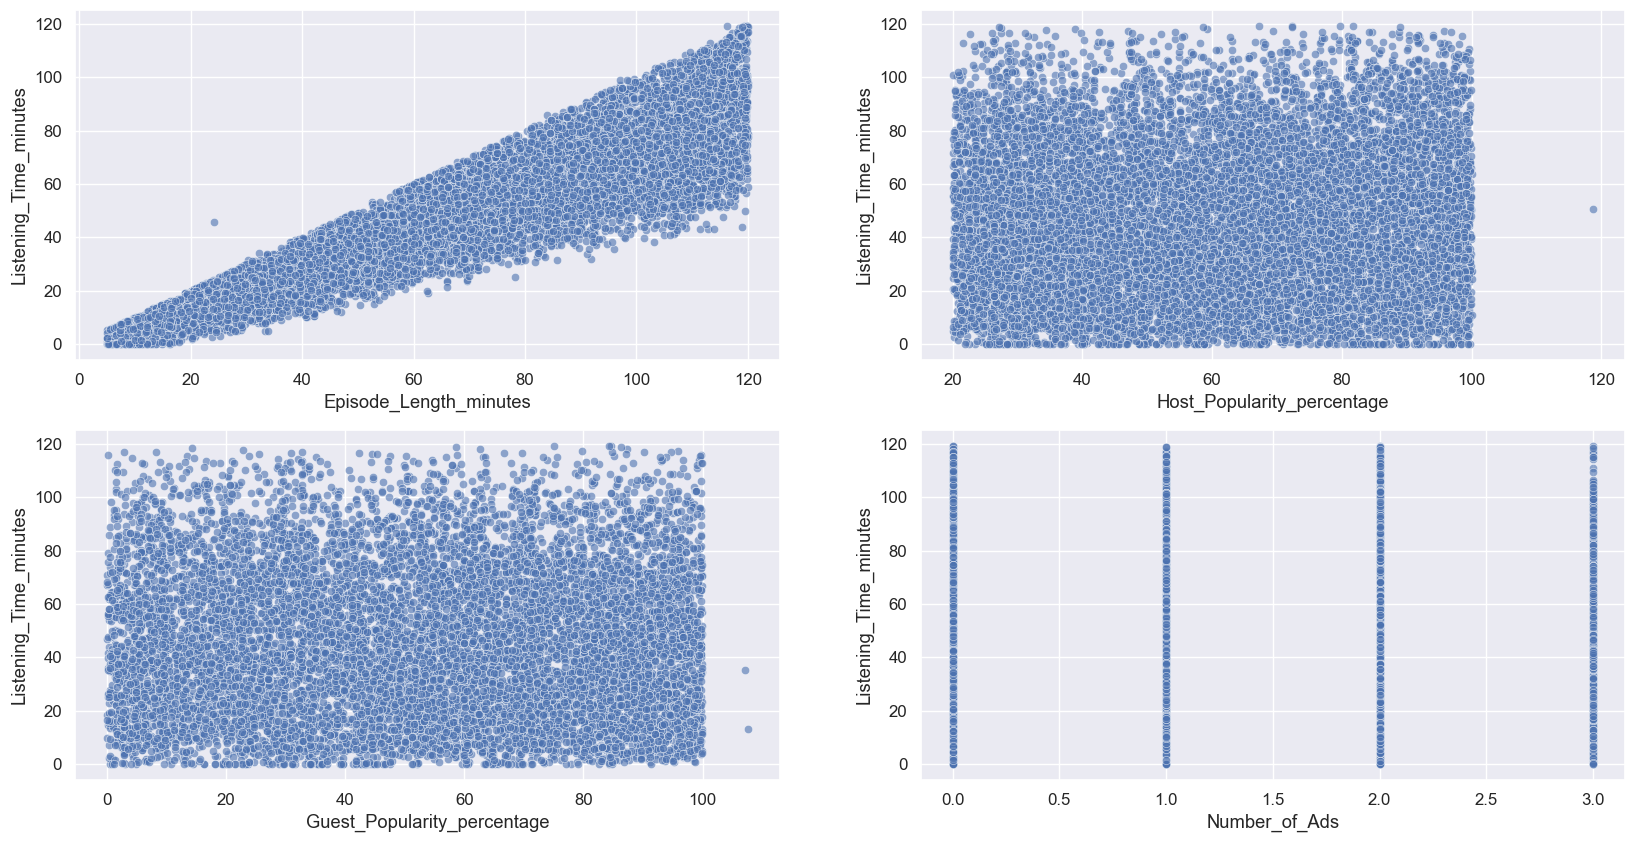

In [44]:
"""
    Draw 4 plots for a sample of 15 000 rows to see how our data in each of the cols look like when compared to Listening_Time_minutes
"""

# take a random sample from our train dataset
sample_df = train_df.sample(n=15000, random_state=20)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

for var, subplot in zip(numerical_features, ax.flatten()):
    sns.scatterplot(
        x=var, 
        y='Listening_Time_minutes', 
        data=sample_df, 
        ax=subplot,
        alpha=0.6
    )

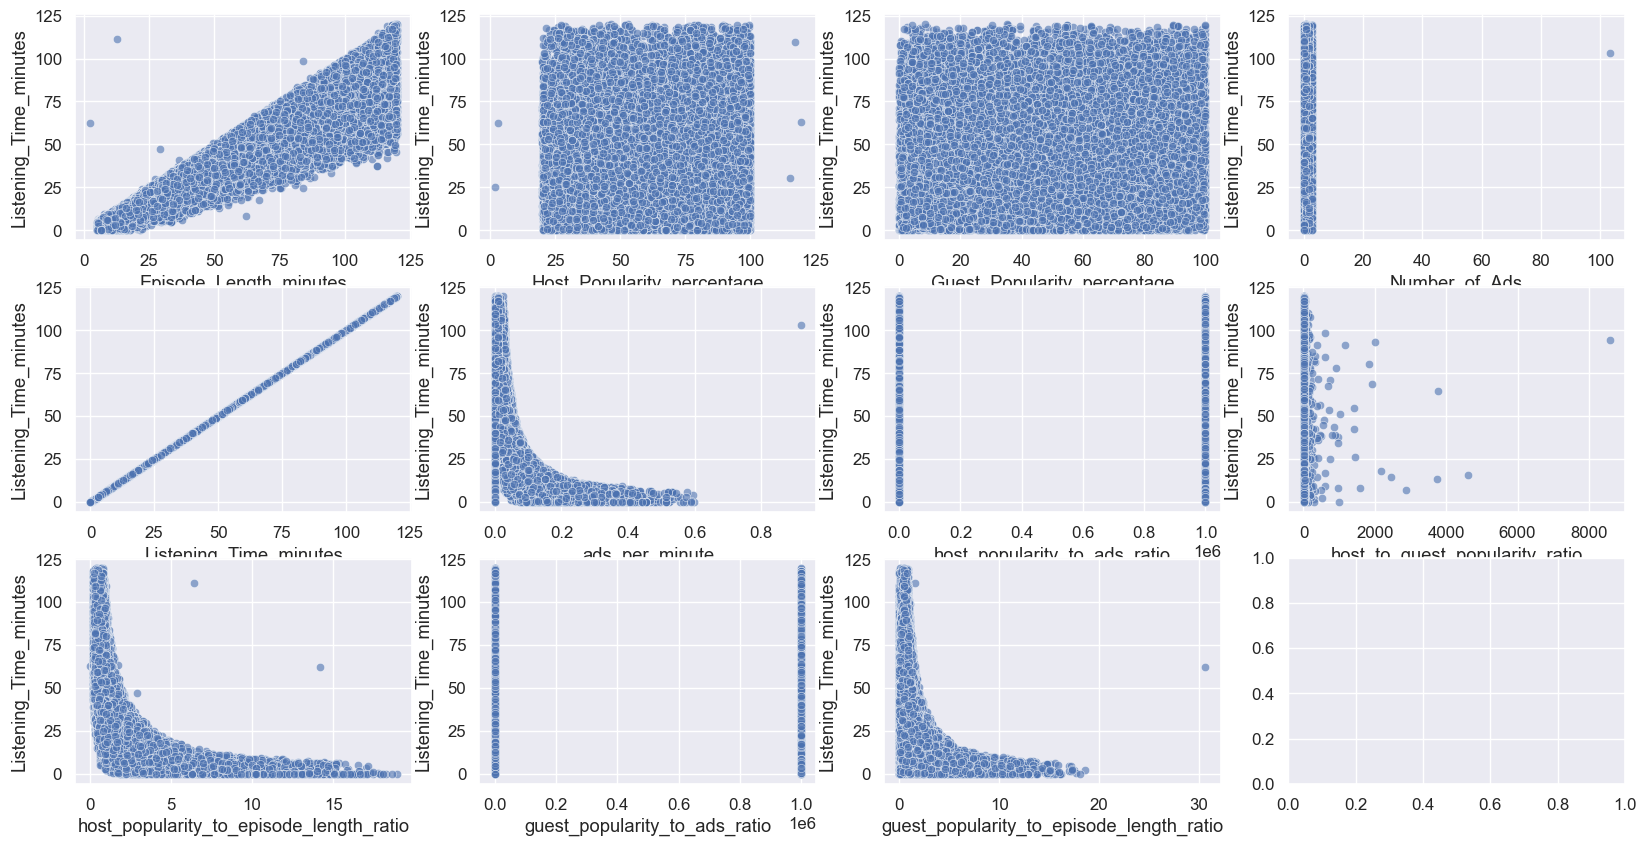

In [45]:
"""
    For know we are left with only 4 numerical features to work with.
    Additionally only one of them seems to be related to listening time length directly.

    We need to find more data to be able to create a good model.
"""

# lets start with creating new features

# ad features
train_df['ads_per_minute'] = train_df['Number_of_Ads'] / train_df['Episode_Length_minutes']

# host popularity features
train_df['host_popularity_to_ads_ratio'] = train_df['Host_Popularity_percentage'] / train_df['Number_of_Ads']
train_df['host_to_guest_popularity_ratio'] = train_df['Host_Popularity_percentage'] / train_df['Guest_Popularity_percentage']
train_df['host_popularity_to_episode_length_ratio'] = train_df['Host_Popularity_percentage'] / train_df['Episode_Length_minutes']

# guest popularity features
train_df['guest_popularity_to_ads_ratio'] = train_df['Guest_Popularity_percentage'] / train_df['Number_of_Ads']
train_df['guest_popularity_to_episode_length_ratio'] = train_df['Guest_Popularity_percentage'] / train_df['Episode_Length_minutes']

# clip values beyond float64
train_df['host_popularity_to_ads_ratio'] = train_df['host_popularity_to_ads_ratio'].clip(lower=0, upper=1000000)
train_df['host_to_guest_popularity_ratio'] = train_df['host_to_guest_popularity_ratio'].clip(lower=0, upper=1000000)
train_df['host_popularity_to_episode_length_ratio'] = train_df['host_popularity_to_episode_length_ratio'].clip(lower=0, upper=1000000)
train_df['guest_popularity_to_ads_ratio'] = train_df['guest_popularity_to_ads_ratio'].clip(lower=0, upper=1000000)
train_df['guest_popularity_to_episode_length_ratio'] = train_df['guest_popularity_to_episode_length_ratio'].clip(lower=0, upper=1000000)


# lets see how it looks like

object_features = [feature for feature in train_df.columns if train_df[feature].dtype == 'object']
numerical_features = [feature for feature in train_df.columns if feature not in object_features]
numerical_features = numerical_features[1:]

# lets increase sample size to 50 000 to see more outliyng values
sample_df = train_df.sample(n=50000, random_state=1)

fig, ax = plt.subplots(3, 4, figsize=(20, 10))

for var, subplot in zip(numerical_features, ax.flatten()):
    sns.scatterplot(
        x=var, 
        y='Listening_Time_minutes', 
        data=sample_df, 
        ax=subplot,
        alpha=0.6
    )


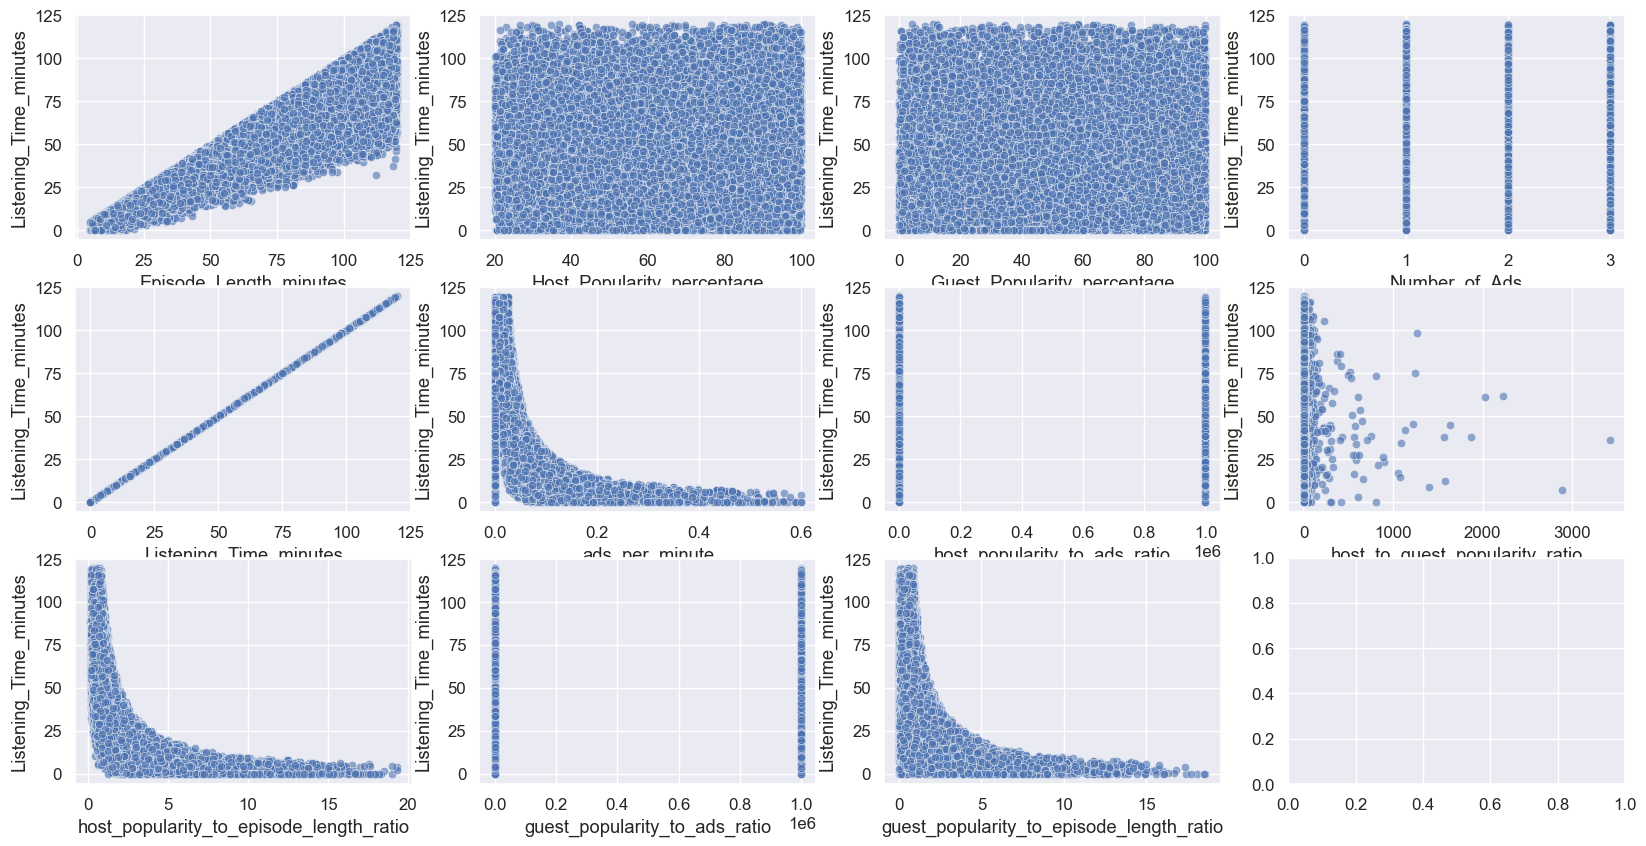

In [51]:
"""
    Lets clean outliers since we can clearly see them in the plots
"""

# drop rows where listening time is greater than episode length
train_df = train_df.drop(train_df[(train_df['Listening_Time_minutes'] > train_df['Episode_Length_minutes'])].index)

# drop rows where number of ads is more than 3
train_df = train_df.drop(train_df[(train_df['Number_of_Ads'] > 3)].index)

# drop rows where guest popularity is over 100
train_df = train_df.drop(train_df[(train_df['Guest_Popularity_percentage'] > 100)].index)

# drop rows where host popularity is over 100
train_df = train_df.drop(train_df[(train_df['Host_Popularity_percentage'] > 100)].index)

# drop rows where host_to_guest popularity ratio is over 4000
train_df = train_df.drop(train_df[(train_df['host_to_guest_popularity_ratio'] > 4000)].index)

# lets see how it looks like
sample_df = train_df.sample(n=50000, random_state=1)

fig, ax = plt.subplots(3, 4, figsize=(20, 10))

for var, subplot in zip(numerical_features, ax.flatten()):
    sns.scatterplot(
        x=var, 
        y='Listening_Time_minutes', 
        data=sample_df, 
        ax=subplot,
        alpha=0.6
    )



In [53]:
"""
    Now that we have cleaned the data, lets see how many rows we deleted
"""

rows_deleted_count = len(original_train_ds) - len(train_df)
rows_deleted_count

2668

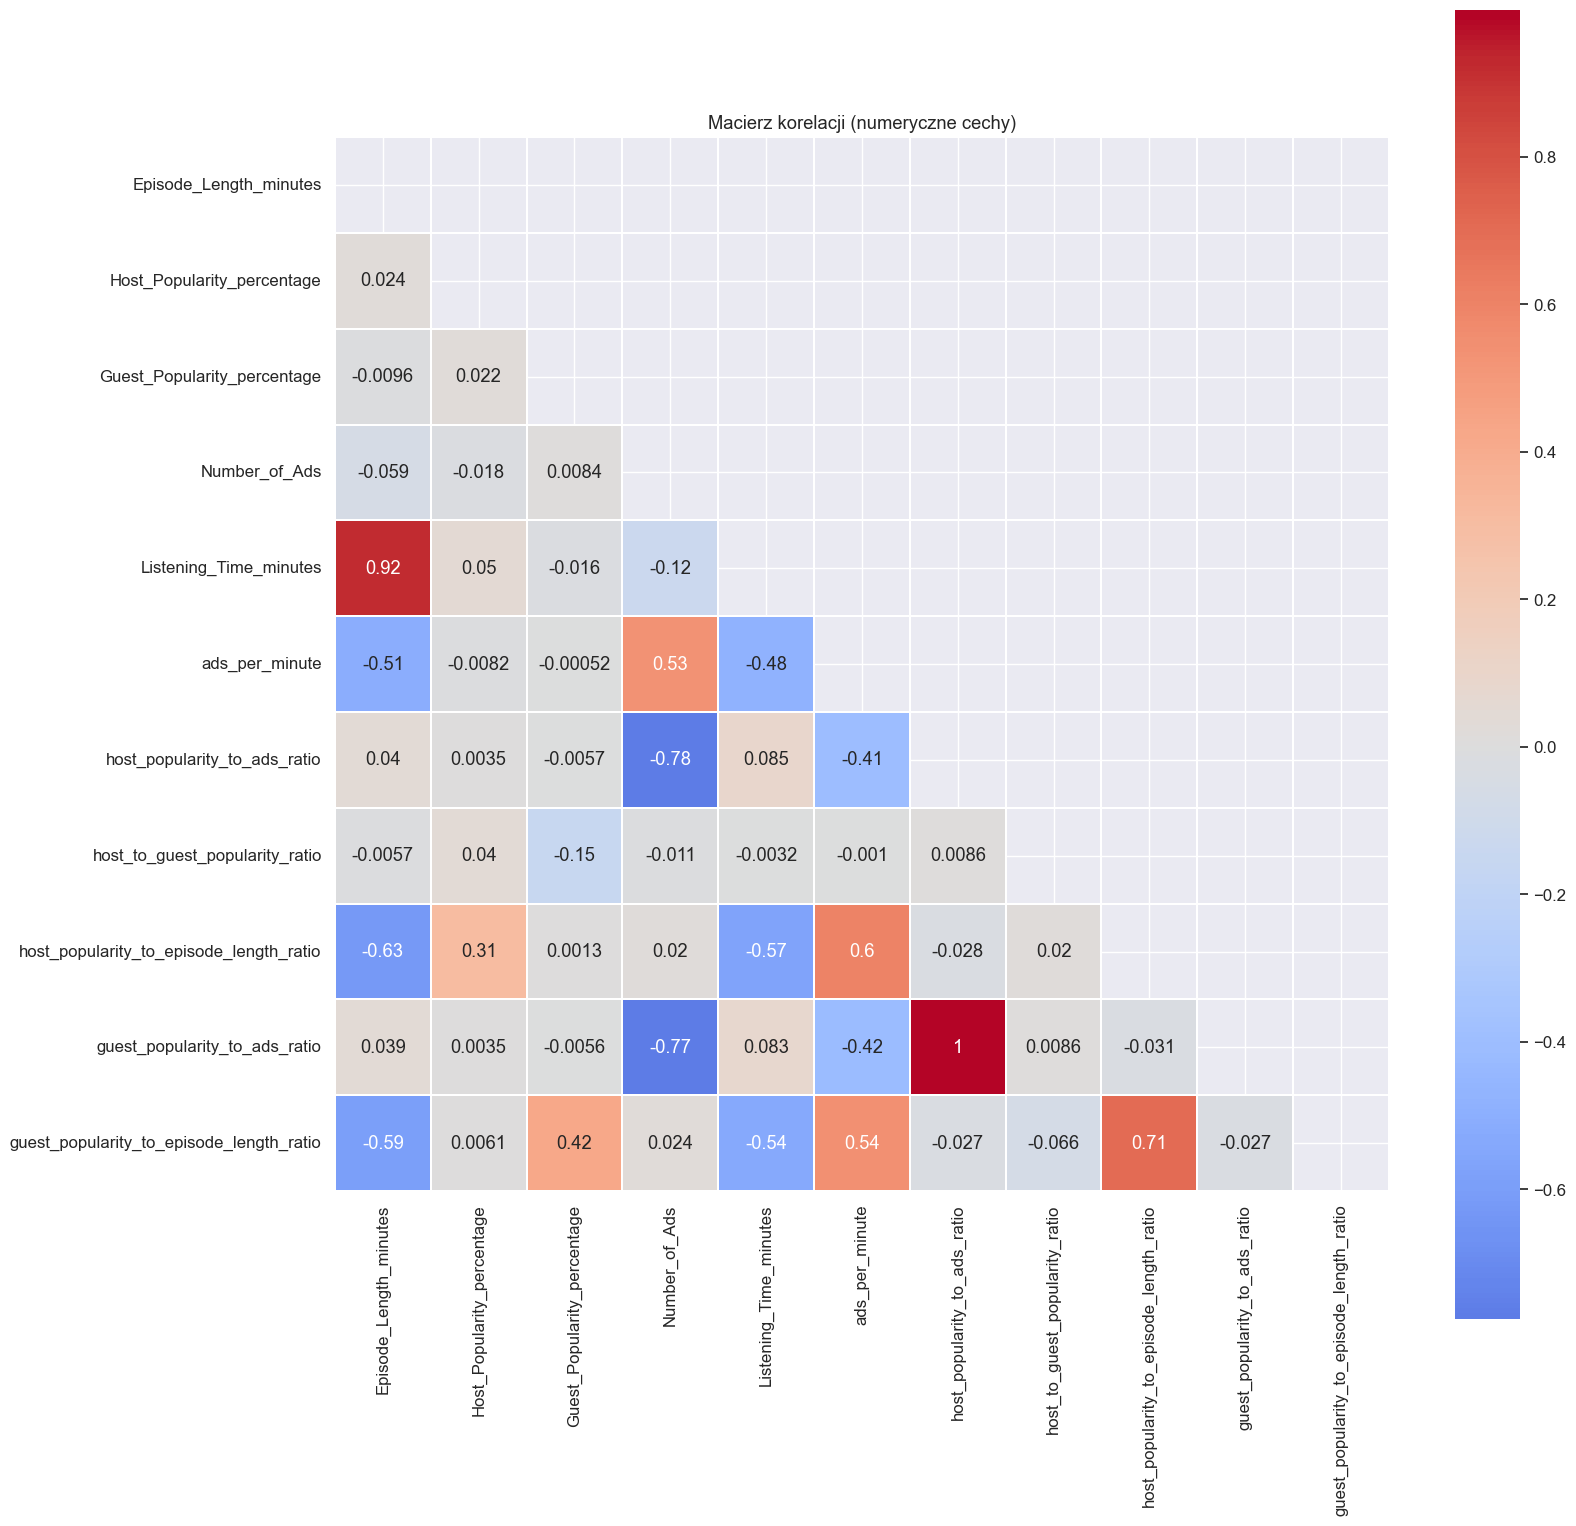

In [ ]:
"""
    Lets draw a heatmap of correlations between numerical features and listening time.
    Explanation:
        Red squares mean that the higher the feature is, the higher corelating feature
        Blue squares mean that the higher the feature is, the lower corelating feature
    source: https://www.kaggle.com/code/manyasinghal912/4th-rank-housing-prices-feature-engineering#Exploratory-Data-Analysis
    Correlation is a great measure to understand the relations between features and target variable. But it only measures linear relationships.
"""

import numpy as np

corr = train_df[numerical_features].corr(method='pearson')

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(font_scale=1.1)
plt.figure(figsize=(17, 17))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm', center=0,
    square=True, linewidths=0.1, cbar=True, annot=True
)
plt.show()


"""
    We can see that there is a strong correlation between episode length and listening time.
    The more ads per minute, the less listening time.
    Both host popularity to ads ratio and guest popularity to ads ratio decrease with listening time.
"""

In [ ]:
"""
    Mutual information measure. It is capable of measuring more complex relationships between features and target variable.
    The ranking shows which features are the most influential for the target variable.
"""

from sklearn.feature_selection import mutual_info_regression

updated_numerical_features = numerical_features.copy()
updated_numerical_features.remove('Listening_Time_minutes')
mutual_df = train_df[updated_numerical_features]

y = train_df['Listening_Time_minutes']

mutual_info = mutual_info_regression(mutual_df.fillna(0), y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] ).style.background_gradient("cool")


,Numerical_Feature_MI
Episode_Length_minutes,2.032410
ads_per_minute,1.082164
host_popularity_to_episode_length_ratio,0.832563
Host_Popularity_percentage,0.762977
host_popularity_to_ads_ratio,0.741992
Guest_Popularity_percentage,0.642254
guest_popularity_to_ads_ratio,0.637461
guest_popularity_to_episode_length_ratio,0.579293
host_to_guest_popularity_ratio,0.358643
Number_of_Ads,0.238935
